## Set things up

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor  # not sure I'm going to use this
from sklearn.model_selection import GridSearchCV

In [2]:
RAW_DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data/WiFiAccessPoint_4weeks.csv"
CLEAN_DATA_SOURCE = "CleanedWiFiAccessPoint_4weeks.csv"

## Read in data

In [3]:
def load_wifi_data(path):
    """
    Read WiFi clientCount .csv file and sum the clientCounts over building and timestamp, bucketed to 5 minutes
    
    Input: filepath the .csv file
    Output: Dataframe with "building", "time_bucket", "clientCount"
    Columns "building" generated from "locationHierarchy", and "time_bucket" generated from "timestamp"
    """
    all_data = pd.read_csv(path, delimiter=",")
    all_data = all_data.rename(columns=lambda x: x.strip())  # get rid of extra spaces in column names

    sum_clientCounts = all_data["clientCount"].sum()
    
    # extract building from 'locationHierarchy' string and deal with unknown buildings
    all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]
    all_data["building"] = all_data["building"].fillna("Unknown")

    # convert timestamp from epoch milliseconds to 5 minute buckets (1000 milliseconds * 60 seconds * 5 minutes)
    all_data["time_bucket"] = all_data["timestamp"].apply(lambda d: 300000*int(d/300000))
    
    # keep only the interesting columns
    all_data = all_data[["time_bucket", "building", "clientCount"]]
    
    # sum data over buildings and time buckets
    all_data = all_data.groupby(["time_bucket", "building"]).sum()  # sort on time first so that new data keeps sequence
    
    assert sum_clientCounts == all_data["clientCount"].sum()  # check that no clientCounts went missing

    return all_data

# if possible read in the cleaned data, otherwise clean the raw data and save
if os.path.isfile(CLEAN_DATA_SOURCE):
    all_data = pd.read_csv(CLEAN_DATA_SOURCE, delimiter=",")
else:
    all_data = load_wifi_data(RAW_DATA_SOURCE)
    all_data.to_csv(CLEAN_DATA_SOURCE)

print(all_data["clientCount"].sum())  # should be 3597531 for one week and 14273111 for 4 weeks

14273111


In [4]:
all_data = all_data.reset_index().drop("index", axis=1)  # get rid of multiindex for StratifiedShuffleSplit
print(all_data)

          time_bucket               building  clientCount
0       1620991800000      03-Science Center           34
1       1620991800000             05-TNW-BIO            1
2       1620991800000             08-BK-City            2
3       1620991800000   19-Studuitzendbureau           13
4       1620991800000                20-Aula           32
...               ...                    ...          ...
306693  1623414900000                 64-HSL           21
306694  1623414900000          66-Fellowship          178
306695  1623414900000  Katalyse Labaratorium           10
306696  1623414900000                Unknown           40
306697  1623414900000           VLL-LAB(TNO)           19

[306698 rows x 3 columns]


## Separate Test Set stratified over buildings

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

          time_bucket              building  clientCount
152479  1622195400000  38-Cultureel Centrum            4
84163   1621656000000                 62-LR            5
92538   1621722300000       25-GreenVillage           18
200037  1622571000000               21-BTUD          167
129572  1622014500000       61-Vliegtuighal           32
...               ...                   ...          ...
298949  1623354000000  19-Studuitzendbureau            1
30540   1621232700000            46-P E lab            0
3937    1621022700000  38-Cultureel Centrum            0
26348   1621199700000             32-OCP-IO           11
268447  1623112800000      32a- Learninglab            0

[245358 rows x 3 columns]


## Create Work days and Student days

In [6]:
uni_hols = (datetime.date(year=2021, month=5, day=5),
            datetime.date(year=2021, month=5, day=13),
            datetime.date(year=2021, month=5, day=14),
            datetime.date(year=2021, month=5, day=24)
           )  # National Holidays and Collective Free days

def roster(date):
    # categorise the days of the academic year at TU Delft between 1 May 2021 and 29 August 2021
    
    if (date > datetime.date(year=2021, month=5, day=16)) and \
       (date < datetime.date(year=2021, month=5, day=22)):
        categorie = "Exam_BSc"
    elif (date > datetime.date(year=2021, month=6, day=15)) and \
         (date < datetime.date(year=2021, month=6, day=19)):
        categorie = "Study_mixed"
    elif (date > datetime.date(year=2021, month=6, day=22)) and \
         (date < datetime.date(year=2021, month=6, day=26)):
        categorie = "Exam_mixed"
    elif (date > datetime.date(year=2021, month=6, day=29)) and \
         (date < datetime.date(year=2021, month=7, day=3)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=8, day=8)) and \
         (date < datetime.date(year=2021, month=8, day=14)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=7, day=4)):
        categorie = "Free"
    else:
        categorie = "Learn"
    return categorie

## Separate predictions and labels

In [7]:
crowd = strat_train_set.drop("clientCount", axis=1)
crowd_labels = strat_train_set["clientCount"].copy()
print(crowd)

          time_bucket              building
152479  1622195400000  38-Cultureel Centrum
84163   1621656000000                 62-LR
92538   1621722300000       25-GreenVillage
200037  1622571000000               21-BTUD
129572  1622014500000       61-Vliegtuighal
...               ...                   ...
298949  1623354000000  19-Studuitzendbureau
30540   1621232700000            46-P E lab
3937    1621022700000  38-Cultureel Centrum
26348   1621199700000             32-OCP-IO
268447  1623112800000      32a- Learninglab

[245358 rows x 2 columns]


In [8]:
assert crowd.isnull().values.any() == False  # check there are no missing values

## Build Transformers

In [9]:
# specify which extra attributes to add to the data
# want to treat these as hyperparameters for grid search
add_day_of_week=False
add_time_of_day=False
add_uni_hols=False
add_weekend=False
add_academic_yr=False

In [10]:
# Set up categories for OneHotEncoder.
# This is needed later for the transformation of small sets that do not contain all the categories.

buildings = list(set(all_data["building"].values))
rosters = ["Exam_BSc", "Study_mixed", "Exam_mixed", "Exam", "Free", "Learn"]  # get a list of all roster categories, SEB could be improved

In [11]:
# Combined the Adder and Transformer so that Grid Search could switch the attributes on and off
class CombinedAdderAndTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_day_of_week=True, add_time_of_day=True, add_uni_hols=True, add_weekend=True, add_academic_yr=True,
                 buildings=None, rosters=None):
        self.add_day_of_week = add_day_of_week
        self.add_time_of_day = add_time_of_day
        self.add_uni_hols = add_uni_hols
        self.add_weekend = add_weekend
        self.add_academic_yr = add_academic_yr
        self.buildings = buildings
        self.rosters = rosters

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_temp = X.copy()
        num_attribs = ["time_bucket"]
        cat_attribs = ["building"]
        all_categories = [self.buildings]
        if self.add_day_of_week:
            X_temp["day_of_week"] = X["time_bucket"].apply(lambda d: datetime.datetime.fromtimestamp(d/1000).weekday())
            num_attribs.extend(["day_of_week"])
        if self.add_time_of_day:
            X_temp["time_of_day"] = X["time_bucket"].apply(lambda d: int(d%86400000))
            num_attribs.extend(["time_of_day"])
        if self.add_uni_hols:
            X_temp["hols"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).date() in uni_hols else 0.)
            num_attribs.extend(["hols"])
        if self.add_weekend:
            X_temp["weekend"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).weekday() > 4 else 0.)
            num_attribs.extend(["weekend"])
        if self.add_academic_yr:
            X_temp["academic_yr"] = X["time_bucket"].apply(lambda d: roster(datetime.datetime.fromtimestamp(d/1000).date()))
            all_categories.append(rosters)
            cat_attribs.extend(["academic_yr"])


        # combine the pipelines based on column type
        coltrans = ColumnTransformer([("num", StandardScaler(), num_attribs),
                                      ("cat", OneHotEncoder(categories=all_categories), cat_attribs)
                                     ])
        X_trans = coltrans.fit_transform(X_temp)
        return X_trans

# Build the Adder, Transformer, Tree Regression pipeline

In [12]:
full_pipeline = Pipeline([
    ('add_attributes', CombinedAdderAndTransformer(add_day_of_week, add_time_of_day, add_uni_hols, add_weekend,
                                                   add_academic_yr, buildings=buildings, rosters=rosters)),
    ('tree_reg',  DecisionTreeRegressor()),
])

# print(full_pipeline.named_steps['add_attributes'])

In [13]:
# check it works
crowd_fitted = full_pipeline.fit(crowd, crowd_labels)
print(crowd_fitted)

Pipeline(steps=[('add_attributes',
                 CombinedAdderAndTransformer(add_academic_yr=False,
                                             add_day_of_week=False,
                                             add_time_of_day=False,
                                             add_uni_hols=False,
                                             add_weekend=False,
                                             buildings=['30-O S', '31-TBM',
                                                        '22-TNW-TN',
                                                        '35-Drebbelweg',
                                                        '66-Fellowship',
                                                        '45-LSL', '46-P E lab',
                                                        'Katalyse Labaratorium',
                                                        '43-EGM', '05-TNW-BIO',
                                                        '23-CITG',
                                 

# Do a Grid Search

In [14]:
if os.path.isfile("tree_grid_search.joblib"):
    grid_search = load("tree_grid_search.joblib")

else:
    # This takes a lot of time
    param_grid = {'add_attributes__add_day_of_week': [True, False], 'add_attributes__add_time_of_day': [True, False],
                  'add_attributes__add_uni_hols': [True, False],
                  'add_attributes__add_weekend': [True, False], 'add_attributes__add_academic_yr': [True, False],
                  'add_attributes__buildings': [buildings], 'add_attributes__rosters': [rosters]}


    grid_search = GridSearchCV(full_pipeline, param_grid, scoring='neg_mean_squared_error', return_train_score=True)

    grid_search.fit(crowd, crowd_labels)
    dump(grid_search, "tree_grid_search.joblib")


In [15]:
grid_search.best_params_

{'add_attributes__add_academic_yr': False,
 'add_attributes__add_day_of_week': True,
 'add_attributes__add_time_of_day': True,
 'add_attributes__add_uni_hols': True,
 'add_attributes__add_weekend': False,
 'add_attributes__buildings': ['36-EWI-HB',
  'Unknown',
  '38-Cultureel Centrum',
  'VLL-LAB(TNO)',
  '22-TNW-TN',
  '05-TNW-BIO',
  '61-Vliegtuighal',
  '30-IKC_ISD-FMVG',
  '31-TBM',
  '36-ESP-Lab',
  '58-TNW-Zuid',
  '23-CITG',
  '60-LMS',
  '26-Bouwcampus',
  '34-3ME',
  '28- WNI',
  '20-Aula',
  '64-HSL',
  '37-Sportcentrum',
  '50-TNW-RID',
  '21-BTUD',
  '45-LSL',
  '66-Fellowship',
  '08-BK-City',
  '25-GreenVillage',
  '33-Pulse',
  '32-OCP-IO',
  '46-P E lab',
  '62-LR',
  '63-Simona',
  '30-O S',
  '32a- Learninglab',
  '03-Science Center',
  'Katalyse Labaratorium',
  '43-EGM',
  '19-Studuitzendbureau',
  '35-Drebbelweg',
  '36-EWI LB_K t/m 3 & HB_K  t/m 2e '],
 'add_attributes__rosters': ['Exam_BSc',
  'Study_mixed',
  'Exam_mixed',
  'Exam',
  'Free',
  'Learn']}

In [16]:
grid_search.best_estimator_

Pipeline(steps=[('add_attributes',
                 CombinedAdderAndTransformer(add_academic_yr=False,
                                             add_weekend=False,
                                             buildings=['36-EWI-HB', 'Unknown',
                                                        '38-Cultureel Centrum',
                                                        'VLL-LAB(TNO)',
                                                        '22-TNW-TN',
                                                        '05-TNW-BIO',
                                                        '61-Vliegtuighal',
                                                        '30-IKC_ISD-FMVG',
                                                        '31-TBM', '36-ESP-Lab',
                                                        '58-TNW-Zuid',
                                                        '23-CITG', '60-LMS',
                                                        '26-Bouwcampus',
           

In [17]:
# take a look at the different permutations
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params['add_attributes__add_day_of_week'],
          params['add_attributes__add_time_of_day'], params['add_attributes__add_uni_hols'],
          params['add_attributes__add_weekend'], params['add_attributes__add_academic_yr'])

8.892092081785636 True True True True True
8.821844305368218 True True True False True
9.693401372076293 True True False True True
9.746899118651973 True True False False True
31.011188377211163 True False True True True
31.010685331206425 True False True False True
31.01002123590578 True False False True True
31.011510569072016 True False False False True
10.118799105609645 False True True True True
11.913757986663898 False True True False True
11.473859190969195 False True False True True
11.625617436253293 False True False False True
31.02002974476997 False False True True True
31.02192193662475 False False True False True
31.01996529849226 False False False True True
31.021907223213272 False False False False True
8.790208868860864 True True True True False
8.777878728183646 True True True False False
9.842157918143524 True True False True False
9.718819451364821 True True False False False
31.011433739302653 True False True True False
31.011615708369867 True False True False False

# Evaluate on Test Set

In [18]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("clientCount", axis=1)
y_test = strat_test_set["clientCount"].copy()

final_tree_predictions = final_model.predict(X_test)

final_tree_mse = mean_squared_error(y_test, final_tree_predictions)
final_tree_rmse = np.sqrt(final_tree_mse)

print('Final root mean squared error for decission tree regressor is ', final_tree_rmse)

Final root mean squared error for decission tree regressor is  7.34077477123023


In [19]:
first_time_stamp = all_data["time_bucket"].min()
last_time_stamp = all_data["time_bucket"].max()

first_ever_sunday = 255600000 - 60*60*1000
week_in_milliseconds = 7 * 24 * 60 * 60 * 1000
first_sunday = int(first_time_stamp / week_in_milliseconds) * week_in_milliseconds + first_ever_sunday

extra_days = 28
latest_time_stamp = last_time_stamp + extra_days*86400000 + 300000

times = list(range(first_time_stamp, latest_time_stamp, 300000))

ticks = []
labels = []
for eptime in range(first_sunday, latest_time_stamp, week_in_milliseconds):
    ticks.append(eptime)
    labels.append(datetime.date.fromtimestamp(int(eptime/1000)))

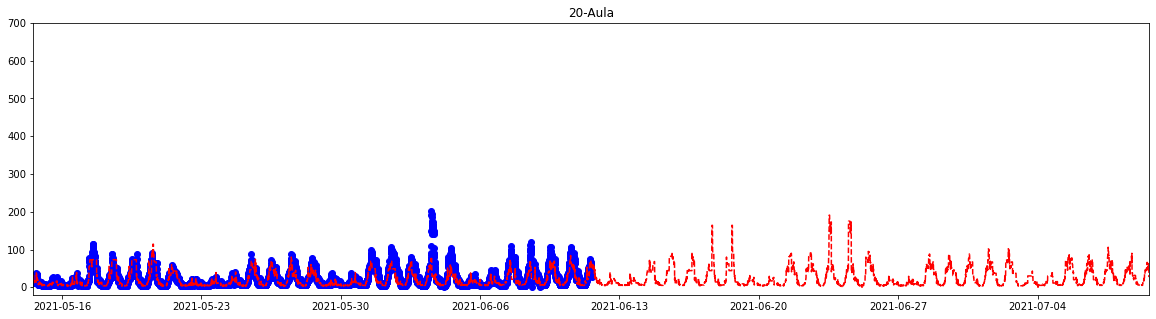

In [34]:
a_building = "20-Aula"
a_building_data = all_data.loc[all_data["building"] == a_building]
estimate = pd.DataFrame()
estimate["time_bucket"] = times
estimate["building"] = a_building

estimate_predictions = final_model.predict(estimate)

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, latest_time_stamp, -20, 700])
plt.xticks(ticks=ticks, labels=labels)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, estimate_predictions, 'r--')
plt.show()

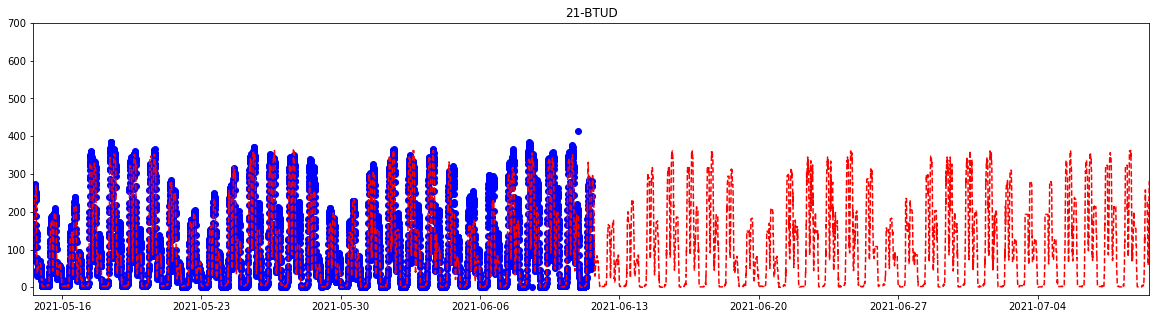

In [21]:
a_building = "21-BTUD"
a_building_data = all_data.loc[all_data["building"] == a_building]
estimate = pd.DataFrame()
estimate["time_bucket"] = times
estimate["building"] = a_building

estimate_predictions = final_model.predict(estimate)

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, latest_time_stamp, -20, 700])
plt.xticks(ticks=ticks, labels=labels)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, estimate_predictions, 'r--')
plt.show()

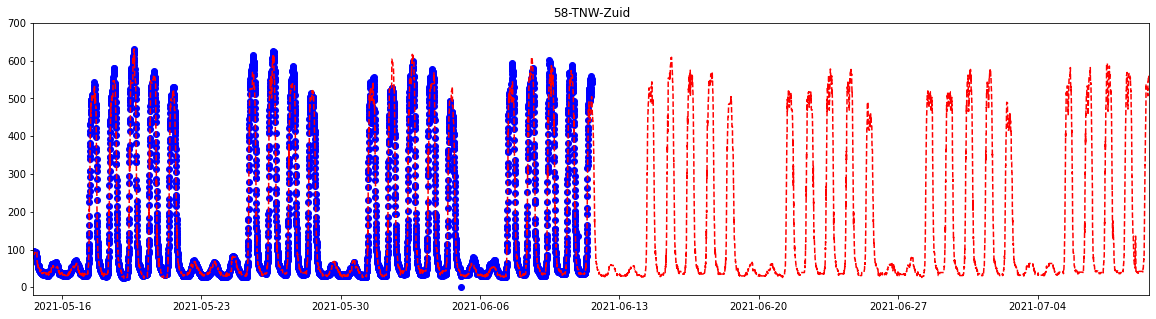

In [22]:
a_building = "58-TNW-Zuid"
a_building_data = all_data.loc[all_data["building"] == a_building]
estimate = pd.DataFrame()
estimate["time_bucket"] = times
estimate["building"] = a_building

estimate_predictions = final_model.predict(estimate)

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, latest_time_stamp, -20, 700])
plt.xticks(ticks=ticks, labels=labels)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, estimate_predictions, 'r--')
plt.show()

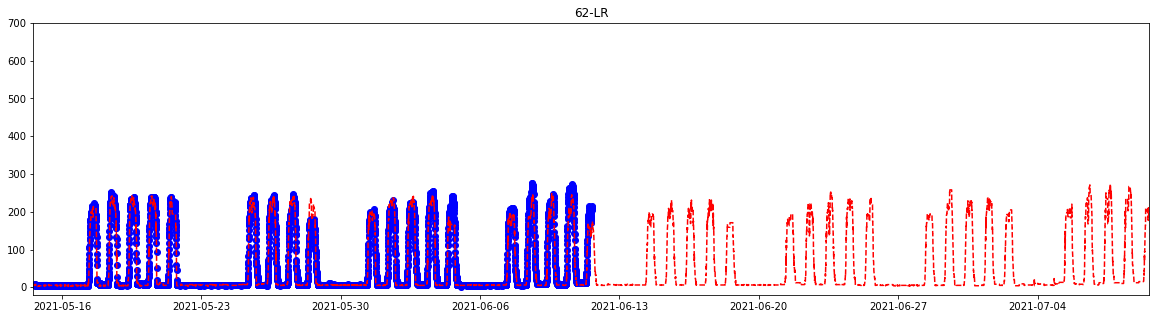

In [23]:
a_building = "62-LR"
a_building_data = all_data.loc[all_data["building"] == a_building]
estimate = pd.DataFrame()
estimate["time_bucket"] = times
estimate["building"] = a_building

estimate_predictions = final_model.predict(estimate)

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, latest_time_stamp, -20, 700])
plt.xticks(ticks=ticks, labels=labels)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, estimate_predictions, 'r--')
plt.show()

## Make prettier graph for blog

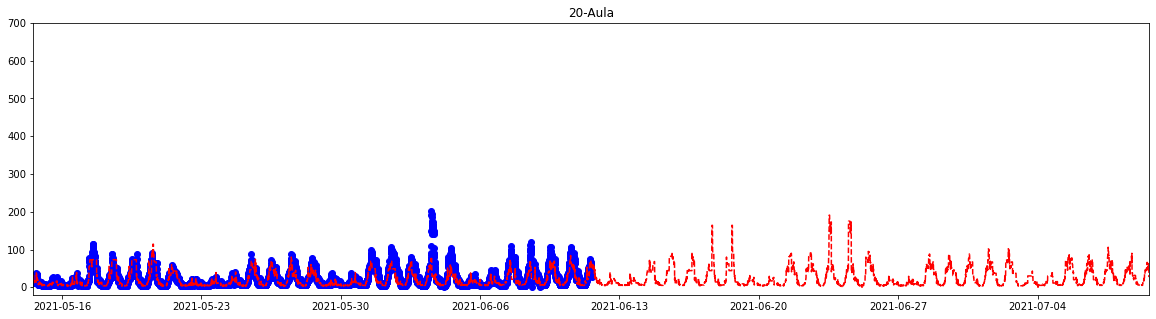

In [35]:
a_building = "20-Aula"
a_building_data = all_data.loc[all_data["building"] == a_building]
estimate = pd.DataFrame()
estimate["time_bucket"] = times
estimate["building"] = a_building

estimate_predictions = final_model.predict(estimate)

plt.figure(figsize=(20,5))
plt.title(a_building)
plt.axis([first_time_stamp, latest_time_stamp, -20, 700])
plt.xticks(ticks=ticks, labels=labels)
plt.plot(a_building_data["time_bucket"], a_building_data["clientCount"], 'bo', times, estimate_predictions, 'r--')
plt.show()

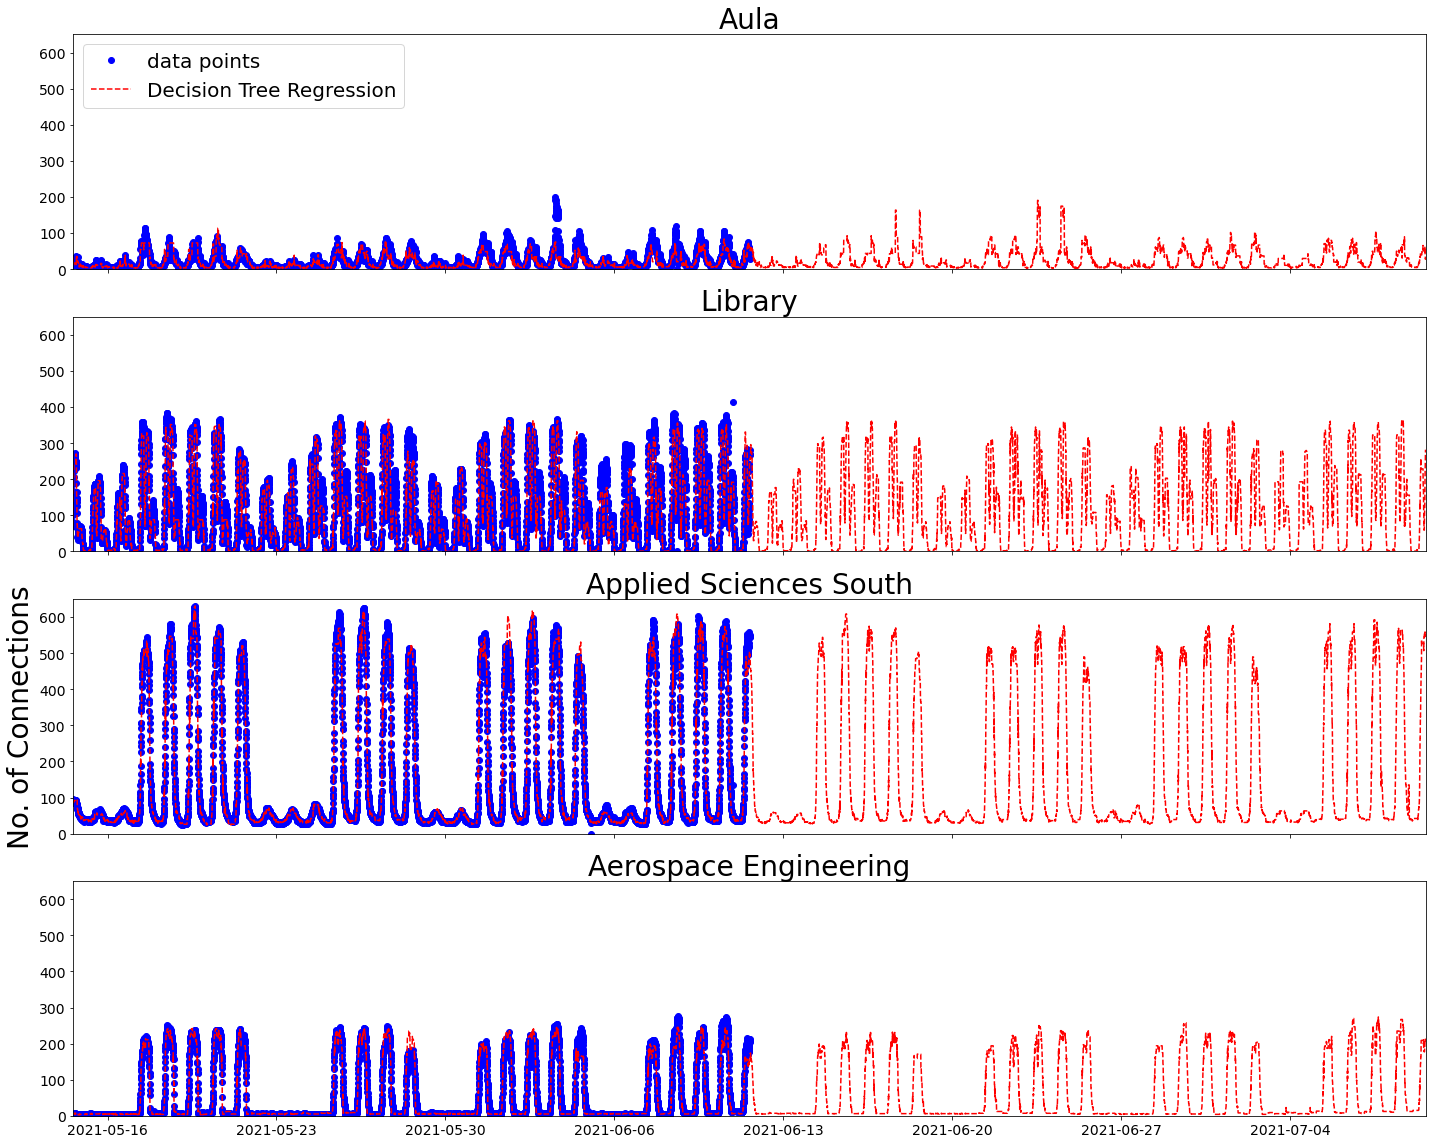

In [53]:
fontsize = 14
fslegend = 20

xticks = []
xlabels = []
for eptime in range(first_sunday, latest_time_stamp, week_in_milliseconds):
    xticks.append(eptime)
    xlabels.append(datetime.date.fromtimestamp(int(eptime/1000)))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,16))

title = {}
title["20-Aula"] = "Aula"
title["21-BTUD"] = "Library"
title["58-TNW-Zuid"] = "Applied Sciences South"
title["62-LR"] = "Aerospace Engineering"

axis = 0
for a_building in ["20-Aula", "21-BTUD", "58-TNW-Zuid", "62-LR"]:
    estimate = pd.DataFrame()
    estimate["time_bucket"] = times
    estimate["building"] = a_building
    estimate_predictions = final_model.predict(estimate)
    
    building_data = all_data.loc[all_data["building"] == a_building]

    ymax = 651  # 121
    yticks = range(0, ymax, 100)
    axes[axis].set_title(title[a_building], size=2*fontsize)
    axes[axis].axis([first_time_stamp, latest_time_stamp, 0, ymax])
    axes[axis].set_xticks(xticks)
    axes[axis].set_xticklabels(xlabels, fontsize=fontsize)
    if (axis == 2): axes[axis].set_ylabel("No. of Connections", fontsize=2*fontsize)
    axes[axis].set_yticks(yticks)
    axes[axis].set_yticklabels(yticks, fontsize=fontsize)
    axes[axis].plot(building_data["time_bucket"], building_data["clientCount"], 'bo', label="data points")
    axes[axis].plot(times, estimate_predictions, 'r--', label="Decision Tree Regression")
    if (axis == 0): axes[axis].legend(loc='upper left', fontsize=fslegend)
    axis +=1

for ax in axes.flat:
    ax.label_outer()
fig.tight_layout()
plt.show()

Still want to do:

* write blog
* illustrate blog with nice graphs

See also: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html